In [1]:
from typing import Callable, List
import numpy as np
import pandas as pd

import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/19 15:36:46 WARN Utils: Your hostname, laelaps-4.local resolves to a loopback address: 127.0.0.1; using 10.138.79.221 instead (on interface en0)
24/03/19 15:36:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/19 15:36:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Data Exploration

Source - https://archive.ics.uci.edu/dataset/320/student+performance 

In [2]:
math_df = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
#portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

## Defining the Benchmark

Reference - 
[1] Garrido, G. M., Near, J., Muhammad, A., He, W., Matzutt, R., & Matthes, F. (2021). Do I get the privacy I need? Benchmarking utility in differential privacy libraries. arXiv preprint arXiv:2109.10789.

[1] defines two attributes as sensitive - _absence_days_ and _final_exam_grade_. They also state that - 

"To set the range bounds for the sensitivity calculation, we selected values based on the domain knowledge of the real-world datasets’ attributes, e.g., for the age attribute, we selected a lower bound and an upper bound of 0 and a 100 years, respectively."

We follow the same setup.

Test Queries for PAC-DB and PipelineDP
1. Count, Sum, Mean, Var
2.  

In [3]:
from tqdm.autonotebook import tqdm
from pacdb import PACDataFrame, PACOptions, SamplerOptions, noise_to_add

### Procedure to run an experiment ###
def run_experiment(df: pyspark.sql.DataFrame,
                   query: Callable,
                   query_name: str,
                   budget_list: List[float] = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.],
                   sample_size: int = 3,
                   sampling_rate: float = 0.5,
                   m: int = 10,
                   tau: int = 1,
                   c: float = 1e-6):
    """
    Run an experiment to compare the accuracy of a query on a DataFrame with and without noise added.

    Args:
        df: PySpark DataFrame to run the query on
        query: function that takes a DataFrame and returns a numeric value
        budget_list: list of MI budgets to test
        sample_size: number of samples per MI (re-runs whole PAC algorithm sample_size times)
        sampling_rate: fraction of data to sample in PAC sampling step
        m: privacy parameter / PAC input, number of times to run PAC sampling
        tau: privacy parameter
        c: privacy parameter
    """
    
    true_answer = query(df, 1.)
    
    def create_pac_df(mi):
        """
        PACDataFrame factory function
        Includes parameters that need to be set for tests
        """
        nonlocal df, query, sampling_rate
        return (PACDataFrame.fromDataFrame(df)
                    .withOptions(PACOptions(trials = m, max_mi = mi, c = c, tau = tau))
                    .withSamplerOptions(SamplerOptions(fraction=sampling_rate))
                    .withQuery(lambda x: query(x, sampling_rate)))

    def results() -> pd.DataFrame:
        """
        Run the query on the DataFrame with and without noise added
        
        Args:
            input_df: DataFrame to run the query on, should be generated by `create_pac_df`
        """
        nonlocal sample_size # Perform `sample_size` estimations for each budget, and save results to `results` list
        nonlocal budget_list

        results: List[dict] = []  # {'mi': float, 'sampled': float, 'noised': float, 'error': float}

        for mi in tqdm(budget_list, position=0): 
            for _ in range(sample_size):
                result = {'mi': mi, 'sampled': None, 'noised': None}
                
                pac_df = create_pac_df(mi=mi)  # create PACDF with this MI

                # Subsampled but not noised release
                Xj = pac_df.sampler.sample()  # generate one sample
                Yj = pac_df._applyQuery(Xj)  # apply query directly to sample
                result['sampled'] = Yj
                
                # Full noised release
                result['noised'] = pac_df.releaseValue(quiet=True)  # perform whole PAC process and release
                
                results.append(result)

        # convert results to pandas DataFrame
        results_df = pd.DataFrame(results)
        return results_df

    def errors(results_df: pd.DataFrame) -> pd.DataFrame:
        """
        Compute the errors from a results (Pandas) DataFrame.
        """
        nonlocal budget_list, true_answer
        errors: List[dict] = []
        # for each value of MI, calculate MSE error for 'sampled' and 'noised' entries
        for mi in budget_list:
            sampled = results_df[results_df['mi'] == mi]['sampled']
            noised = results_df[results_df['mi'] == mi]['noised']
            error = {
                'mi': mi,
                'sampled': np.mean((sampled - true_answer) ** 2),
                'sampled_errorbar': np.std((sampled - true_answer) ** 2),
                'noised': np.mean((noised - true_answer) ** 2),
                'noised_errorbar': np.std((noised - true_answer) ** 2),
            }
            errors.append(error)

        errors_df = pd.DataFrame(errors)
        return errors_df

    def plot_errors(errors_df: pd.DataFrame):
        nonlocal query_name, budget_list
        fig, ax = plt.subplots(figsize=(6.4*(3/4), 4.8*(3/4)))

        plt.errorbar(errors_df['mi'], errors_df['sampled'], fmt='b.', yerr=errors_df['sampled_errorbar'], capsize=3, label='Subsampled Error')
        plt.errorbar(errors_df['mi'], errors_df['noised'], fmt='r.', yerr=errors_df['noised_errorbar'], capsize=3, label='Private Error')

        plt.xscale('log', base=2)
        budget_labels = [r'$\frac{1}{val}$'.replace("val", str(int(1/val))) if val < 1 else f'${int(val)}$' for val in budget_list]
        plt.xticks(budget_list, budget_labels)

        ax.set_axisbelow(True)
        plt.grid(True)

        plt.title(f'{query_name.title()} Accuracy')
        plt.xlabel('Mutual Information (Log Scale)')
        plt.ylabel('Error (MSE)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figs/{query_name.lower()}-accuracy.png")

    display(f"Experiment: {query_name}")
    display(f"The 'true answer' run directly on the whole dataset is {true_answer}")

    display(f"The results of {sample_size} trials at each MI budget are:")
    results_df = results()
    results_df.to_pickle(f"experiment_outputs/{query_name.lower()}-results.pkl")
    display(results_df)

    display(f"The computed errors of the results are:")
    errors_df = errors(results_df)
    errors_df.to_pickle(f"experiment_outputs/{query_name.lower()}-errors.pkl")
    display(errors_df)

    plot_errors(errors_df)

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_11697/2336843472.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Count

'Experiment: count'

"The 'true answer' run directly on the whole dataset is 151.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,140.0,-19854.060154
1,0.015625,166.0,776.959457
2,0.015625,154.0,33926.343104
3,0.031250,158.0,-7608.974510
4,0.031250,154.0,8367.541829
5,0.031250,158.0,-2535.700774
6,0.062500,158.0,549.198088
7,0.062500,142.0,-0.336780
8,0.062500,156.0,3742.561865
9,0.125000,160.0,-186.186079


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,118.333333,88.201789,5.137894e+08,4.724364e+08
1,0.031250,35.666667,18.856181,4.498238e+07,2.686872e+07
2,0.062500,51.666667,22.939534,4.360260e+06,6.038279e+06
3,0.125000,59.666667,15.084945,3.493325e+06,2.534835e+06
4,0.250000,49.000000,51.845926,1.684170e+05,1.866095e+05
5,0.500000,81.000000,62.992063,8.227554e+05,1.019288e+06
6,1.000000,150.333333,151.836169,4.901801e+04,6.352872e+04
7,2.000000,249.000000,147.945936,2.132523e+04,1.689145e+04
8,4.000000,51.666667,49.459299,1.073479e+04,4.556640e+03


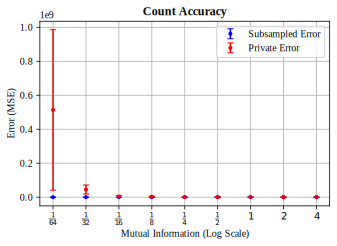

In [5]:
df = math_df.filter(math_df["absences"] >= 5)

def query(df, sampling_rate):
    return float(df.count()) * (1./sampling_rate)

run_experiment(df, query, "count", sample_size=3, sampling_rate=0.5, m=50, tau=1, c=1e-6)

## Sum

'Experiment: sum'

"The 'true answer' run directly on the whole dataset is 124.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,110.0,-2447.889933
1,0.015625,98.0,-43641.169663
2,0.015625,116.0,13321.711840
3,0.031250,98.0,-5172.235708
4,0.031250,124.0,12274.932723
5,0.031250,102.0,-22563.567786
6,0.062500,94.0,-24375.012223
7,0.062500,120.0,-8565.485067
8,0.062500,138.0,-5878.179979
9,0.125000,130.0,3396.134841


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,312.000000,262.967679,6.987281e+08,8.630254e+08
1,0.031250,386.666667,284.428472,2.301403e+08,2.070706e+08
2,0.062500,370.666667,381.440544,2.372450e+08,2.571547e+08
3,0.125000,737.333333,648.611508,8.449979e+06,4.071611e+06
4,0.250000,228.000000,316.783838,1.981383e+07,1.145252e+07
5,0.500000,277.333333,235.634368,1.270828e+06,7.394050e+05
6,1.000000,72.000000,87.817994,6.979159e+04,6.943708e+04
7,2.000000,129.333333,20.741799,1.246112e+05,1.614334e+05
8,4.000000,130.666667,92.395286,1.287348e+04,1.460711e+04


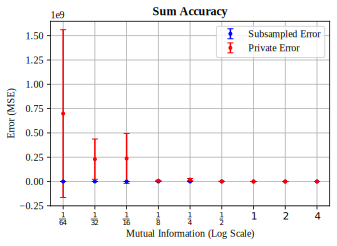

In [6]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter(df["Mjob"] == "at_home").agg({"studytime": "sum"}).collect()[0][0]) * (1./sampling_rate)

run_experiment(df, query, "sum", sample_size=3, m=50, tau=1, c=1e-6)

## Singular result

'Experiment: singular result'

"The 'true answer' run directly on the whole dataset is 1.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,0.0,-22.227683
1,0.015625,2.0,218.162793
2,0.015625,2.0,-310.358410
3,0.031250,2.0,100.686041
4,0.031250,2.0,-145.115035
5,0.031250,2.0,85.940386
6,0.062500,0.0,-15.465154
7,0.062500,0.0,-48.757623
8,0.062500,0.0,7.783085
9,0.125000,2.0,8.729821


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,1.0,0.0,48214.421119,39364.052218
1,0.031250,1.0,0.0,12833.926401,6123.206227
2,0.062500,1.0,0.0,930.977520,1096.227645
3,0.125000,1.0,0.0,85.947681,43.813313
4,0.250000,1.0,0.0,12.230660,9.139701
5,0.500000,1.0,0.0,29.972719,41.557791
6,1.000000,1.0,0.0,3.489528,2.459391
7,2.000000,1.0,0.0,3.758867,4.418925
8,4.000000,1.0,0.0,0.392748,0.279836


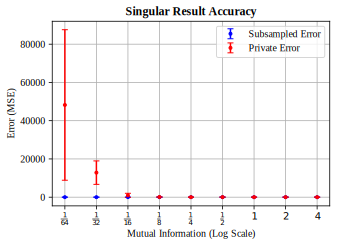

In [7]:
df = math_df

def query(df, sampling_rate):
    return df.filter((df["absences"] > 20) & (df["Mjob"] == "at_home")).count() * (1./sampling_rate)

run_experiment(df, query, "singular result", sample_size=3, m=50, tau=1, c=1e-6)

## Max

'Experiment: max'

"The 'true answer' run directly on the whole dataset is 75"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,56,28938.440613
1,0.015625,75,38443.207511
2,0.015625,75,-13332.567200
3,0.031250,40,-19967.948434
4,0.031250,75,1023.566270
5,0.031250,75,-11386.268069
6,0.062500,54,6470.698493
7,0.062500,54,6366.236174
8,0.062500,75,2411.217868
9,0.125000,56,4411.775041


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,120.333333,170.177032,8.283268e+08,5.276131e+08
1,0.031250,408.333333,577.470538,1.779934e+08,1.669234e+08
2,0.062500,294.000000,207.889394,2.864751e+07,1.640644e+07
3,0.125000,240.666667,170.177032,1.773722e+07,4.625514e+06
4,0.250000,120.333333,170.177032,2.555102e+05,3.272470e+05
5,0.500000,0.000000,0.000000,7.919058e+05,4.973300e+05
6,1.000000,240.666667,170.177032,3.488094e+05,4.459397e+05
7,2.000000,0.000000,0.000000,2.641305e+03,1.525139e+03
8,4.000000,294.000000,207.889394,1.816161e+04,1.918978e+04


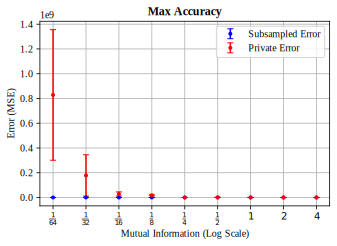

In [8]:
df = math_df

def query(df, sampling_rate):
    return df.agg({"absences": "max"}).collect()[0][0]

run_experiment(df, query, "max", sample_size=3, m=50, tau=1, c=1e-6)

## Aggregate Stats in case of skewed distribution

'Experiment: count aggregation on skewed data'

"The 'true answer' run directly on the whole dataset is 90.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,102.0,6267.878779
1,0.015625,100.0,-5216.726341
2,0.015625,92.0,-3685.208977
3,0.031250,74.0,678.151931
4,0.031250,94.0,-10664.688340
5,0.031250,82.0,-6250.179238
6,0.062500,80.0,-276.272905
7,0.062500,98.0,-2020.109451
8,0.062500,106.0,2069.696635
9,0.125000,86.0,-2841.318100


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,82.666667,58.454161,2.685991e+07,9.806119e+06
1,0.031250,112.000000,103.691851,5.206904e+07,4.782063e+07
2,0.062500,140.000000,83.330667,2.835306e+06,1.922373e+06
3,0.125000,144.000000,181.019336,5.174610e+06,3.166001e+06
4,0.250000,2.666667,1.885618,4.133569e+05,5.740537e+05
5,0.500000,61.333333,59.896207,1.188350e+05,1.584988e+05
6,1.000000,17.333333,14.727148,2.645220e+04,3.723426e+04
7,2.000000,102.666667,108.730043,6.647381e+04,7.869621e+04
8,4.000000,262.666667,143.864133,3.500553e+03,2.309476e+03


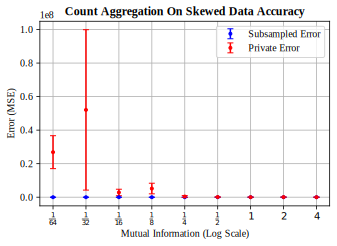

In [9]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter(col("guardian") == "father").count()) * (1./sampling_rate)

run_experiment(df, query, "count aggregation on skewed data", sample_size=3, m=50, tau=1, c=1e-6)

## Multiple Predicates - Apply first

'Experiment: multiple predicates, apply first'

"The 'true answer' run directly on the whole dataset is 8.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,8.0,-266.555091
1,0.015625,6.0,628.171420
2,0.015625,12.0,-469.832057
3,0.031250,6.0,337.751652
4,0.031250,12.0,-267.077118
5,0.031250,10.0,-214.099178
6,0.062500,4.0,395.467462
7,0.062500,6.0,-174.069294
8,0.062500,8.0,-212.341273
9,0.125000,6.0,90.168673


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,6.666667,6.798693,229438.854232,126245.936582
1,0.031250,8.000000,5.656854,77910.539311,24305.067891
2,0.062500,6.666667,6.798693,77276.845990,51897.961329
3,0.125000,2.666667,1.885618,4244.038336,2381.034600
4,0.250000,6.666667,6.798693,4382.995633,2749.341642
5,0.500000,26.666667,27.194771,2507.832100,3520.916586
6,1.000000,6.666667,6.798693,240.977316,326.662639
7,2.000000,17.333333,14.727148,170.580735,150.711305
8,4.000000,22.666667,29.272665,22.706609,16.643250


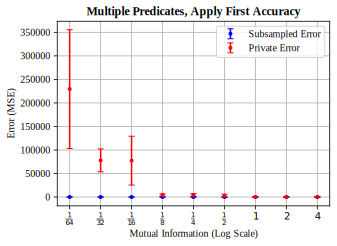

In [10]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter((df["absences"] > 10) & (df["Mjob"] == "at_home")).count()) * (1./sampling_rate)

run_experiment(df, query, "multiple predicates, apply first", sample_size=3, m=50, tau=1, c=1e-6)

## Multiple Predicates - Apply 1 filter, sample, then apply next filter

'Experiment: multiple predicates: filter, sample, filter'

"The 'true answer' run directly on the whole dataset is 8.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,10.0,1249.731571
1,0.015625,4.0,1671.279050
2,0.015625,2.0,1704.409382
3,0.031250,4.0,-1100.761537
4,0.031250,14.0,209.122734
5,0.031250,12.0,-650.104576
6,0.062500,10.0,167.641731
7,0.062500,12.0,90.392472
8,0.062500,4.0,-653.241733
9,0.125000,6.0,-67.773060


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,18.666667,13.199327,2.395400e+06,605225.682195
1,0.031250,22.666667,9.428090,5.676347e+05,494601.677544
2,0.062500,12.000000,5.656854,1.565049e+05,198656.850011
3,0.125000,2.666667,1.885618,7.485293e+03,6431.651347
4,0.250000,4.000000,0.000000,4.209884e+03,4836.649327
5,0.500000,2.666667,1.885618,7.562472e+01,83.372341
6,1.000000,2.666667,1.885618,2.544008e+02,131.509801
7,2.000000,5.333333,7.542472,1.777894e+01,16.182428
8,4.000000,24.000000,28.284271,2.242370e+01,27.696770


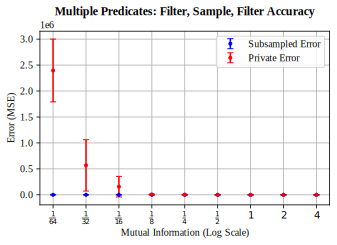

In [11]:
df = math_df.filter((math_df["absences"] > 10))

def query(df, sampling_rate):
    return float(df.filter((df["Mjob"] == "at_home")).count()) * (1./sampling_rate)

run_experiment(df, query, "multiple predicates: filter, sample, filter", sample_size=3, m=50, tau=1, c=1e-6)

## Mean

PAC-count / PAC-sum vs PAC-mean

## Var

σ^2=n∑i=1 ​(xi​−x)^2 / n 

(Chorus does not implement variance---find out why?)​